In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch

In [5]:
### einlesen der Daten von Real 3, VR 2 und MVC

data_real3 = pd.read_csv('data_test/2025-11-13-10-07_BA_Project_Real_3.csv', delimiter=';', skiprows = 3)
data_vr2 = pd.read_csv('data_test/2025-11-13-10-26_BA_Project_VR_2.csv', delimiter=';', skiprows = 3)
data_mvc = pd.read_csv('data_test/2025-11-13-09-47_BA_Project_MVC.csv', delimiter=';', skiprows = 3)

/var/folders/pk/qwd8tnzs0kl2srxyknrb5lt00000gn/T/ipykernel_49028/558730978.py:3: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  data_real3 = pd.read_csv('data_test/2025-11-13-10-07_BA_Project_Real_3.csv', delimiter=';', skiprows = 3)
/var/folders/pk/qwd8tnzs0kl2srxyknrb5lt00000gn/T/ipykernel_49028/558730978.py:4: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  data_vr2 = pd.read_csv('data_test/2025-11-13-10-26_BA_Project_VR_2.csv', delimiter=';', skiprows = 3)
/var/folders/pk/qwd8tnzs0kl2srxyknrb5lt00000gn/T/ipykernel_49028/558730978.py:5: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  data_mvc = pd.read_csv('data_test/2025-11-13-09-47_BA_Project_MVC.csv', delimiter=';', skiprows = 3)


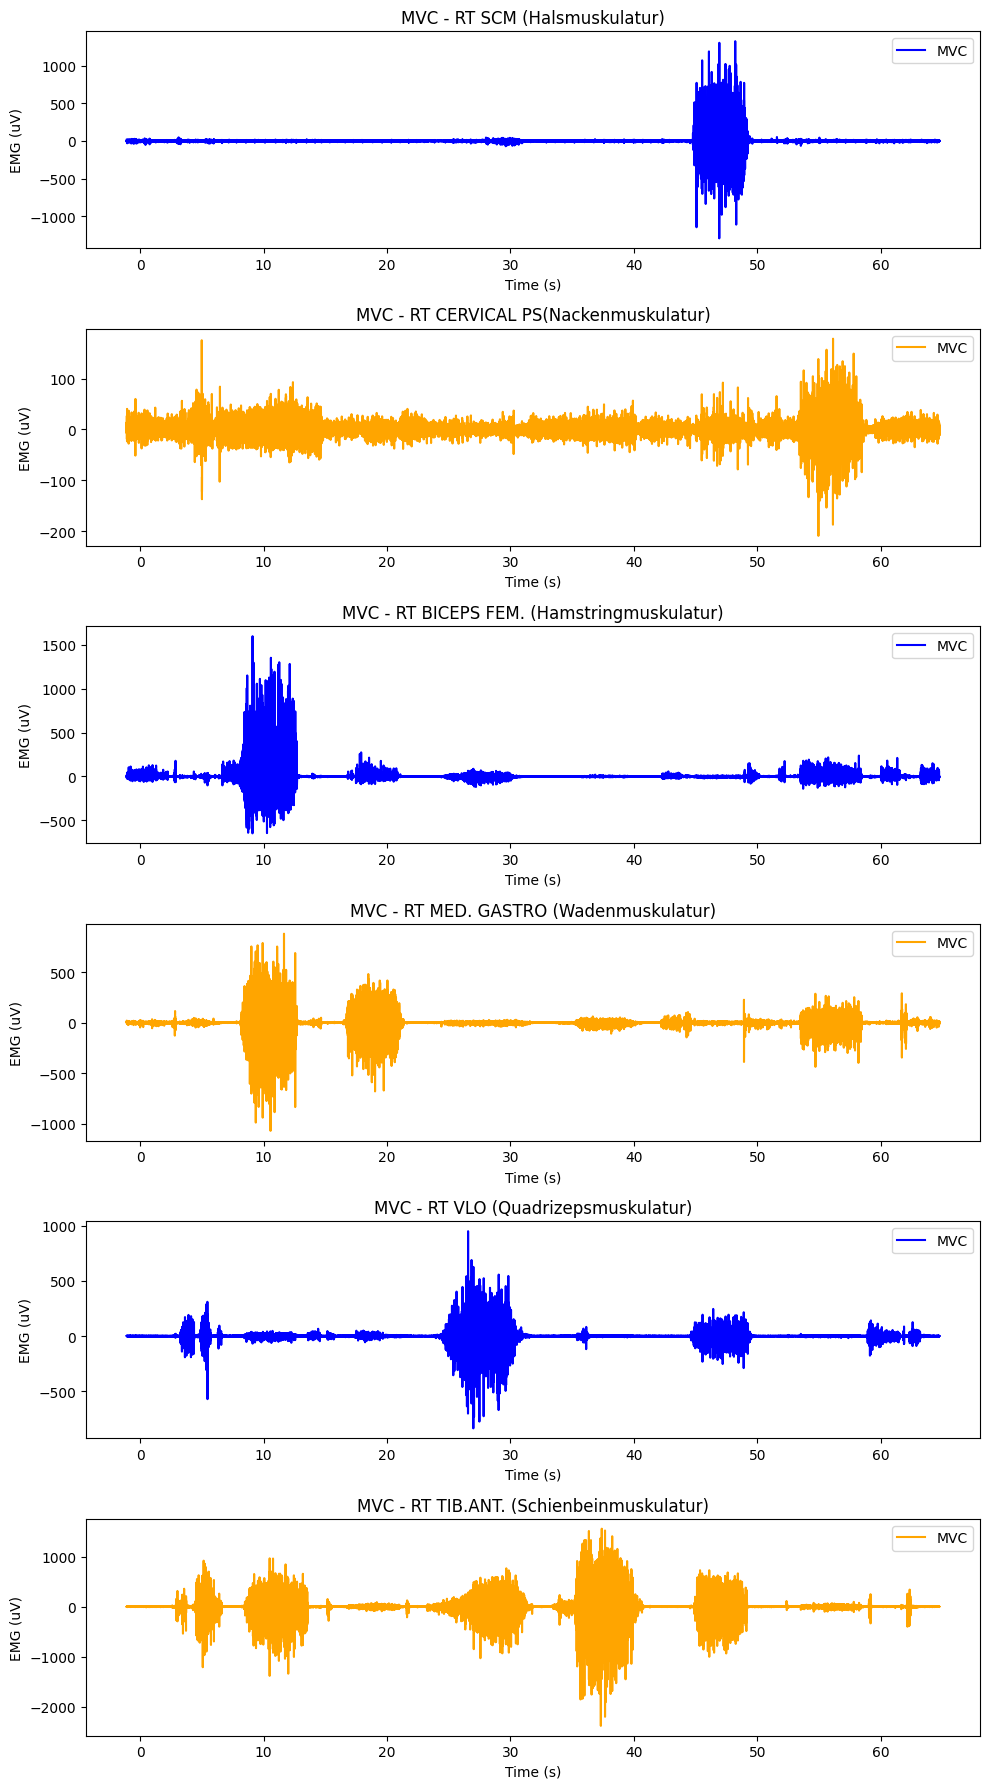

In [6]:
### Plotten der MVC Daten

plt.figure(figsize=(10, 18))
plt.subplot(6, 1, 1)
plt.plot(data_mvc['time'], data_mvc['RT SCM (uV)'], label='MVC', color='blue')
plt.title('MVC - RT SCM (Halsmuskulatur)')
plt.xlabel('Time (s)')
plt.ylabel('EMG (uV)')
plt.legend()

plt.subplot(6, 1, 2)
plt.plot(data_mvc['time'], data_mvc['RT CERVICAL PS (uV)'], label='MVC', color='orange')
plt.title('MVC - RT CERVICAL PS(Nackenmuskulatur)')
plt.xlabel('Time (s)')
plt.ylabel('EMG (uV)')
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(data_mvc['time'], data_mvc['RT BICEPS FEM. (uV)'], label='MVC', color='blue')
plt.title('MVC - RT BICEPS FEM. (Hamstringmuskulatur)')
plt.xlabel('Time (s)')
plt.ylabel('EMG (uV)')
plt.legend()

plt.subplot(6, 1, 4)
plt.plot(data_mvc['time'], data_mvc['RT MED. GASTRO (uV)'], label='MVC', color='orange')
plt.title('MVC - RT MED. GASTRO (Wadenmuskulatur)')
plt.xlabel('Time (s)')
plt.ylabel('EMG (uV)')
plt.legend()

plt.subplot(6, 1, 5)
plt.plot(data_mvc['time'], data_mvc['RT VLO (uV)'], label='MVC', color='blue')
plt.title('MVC - RT VLO (Quadrizepsmuskulatur)')
plt.xlabel('Time (s)')
plt.ylabel('EMG (uV)')
plt.legend()

plt.subplot(6, 1, 6)
plt.plot(data_mvc['time'], data_mvc['RT TIB.ANT. (uV)'], label='MVC', color='orange')
plt.title('MVC - RT TIB.ANT. (Schienbeinmuskulatur)')
plt.xlabel('Time (s)')
plt.ylabel('EMG (uV)')
plt.legend()

plt.tight_layout()
plt.show()

Filtering (30–500 Hz + 50 ms RMS) abgeschlossen.


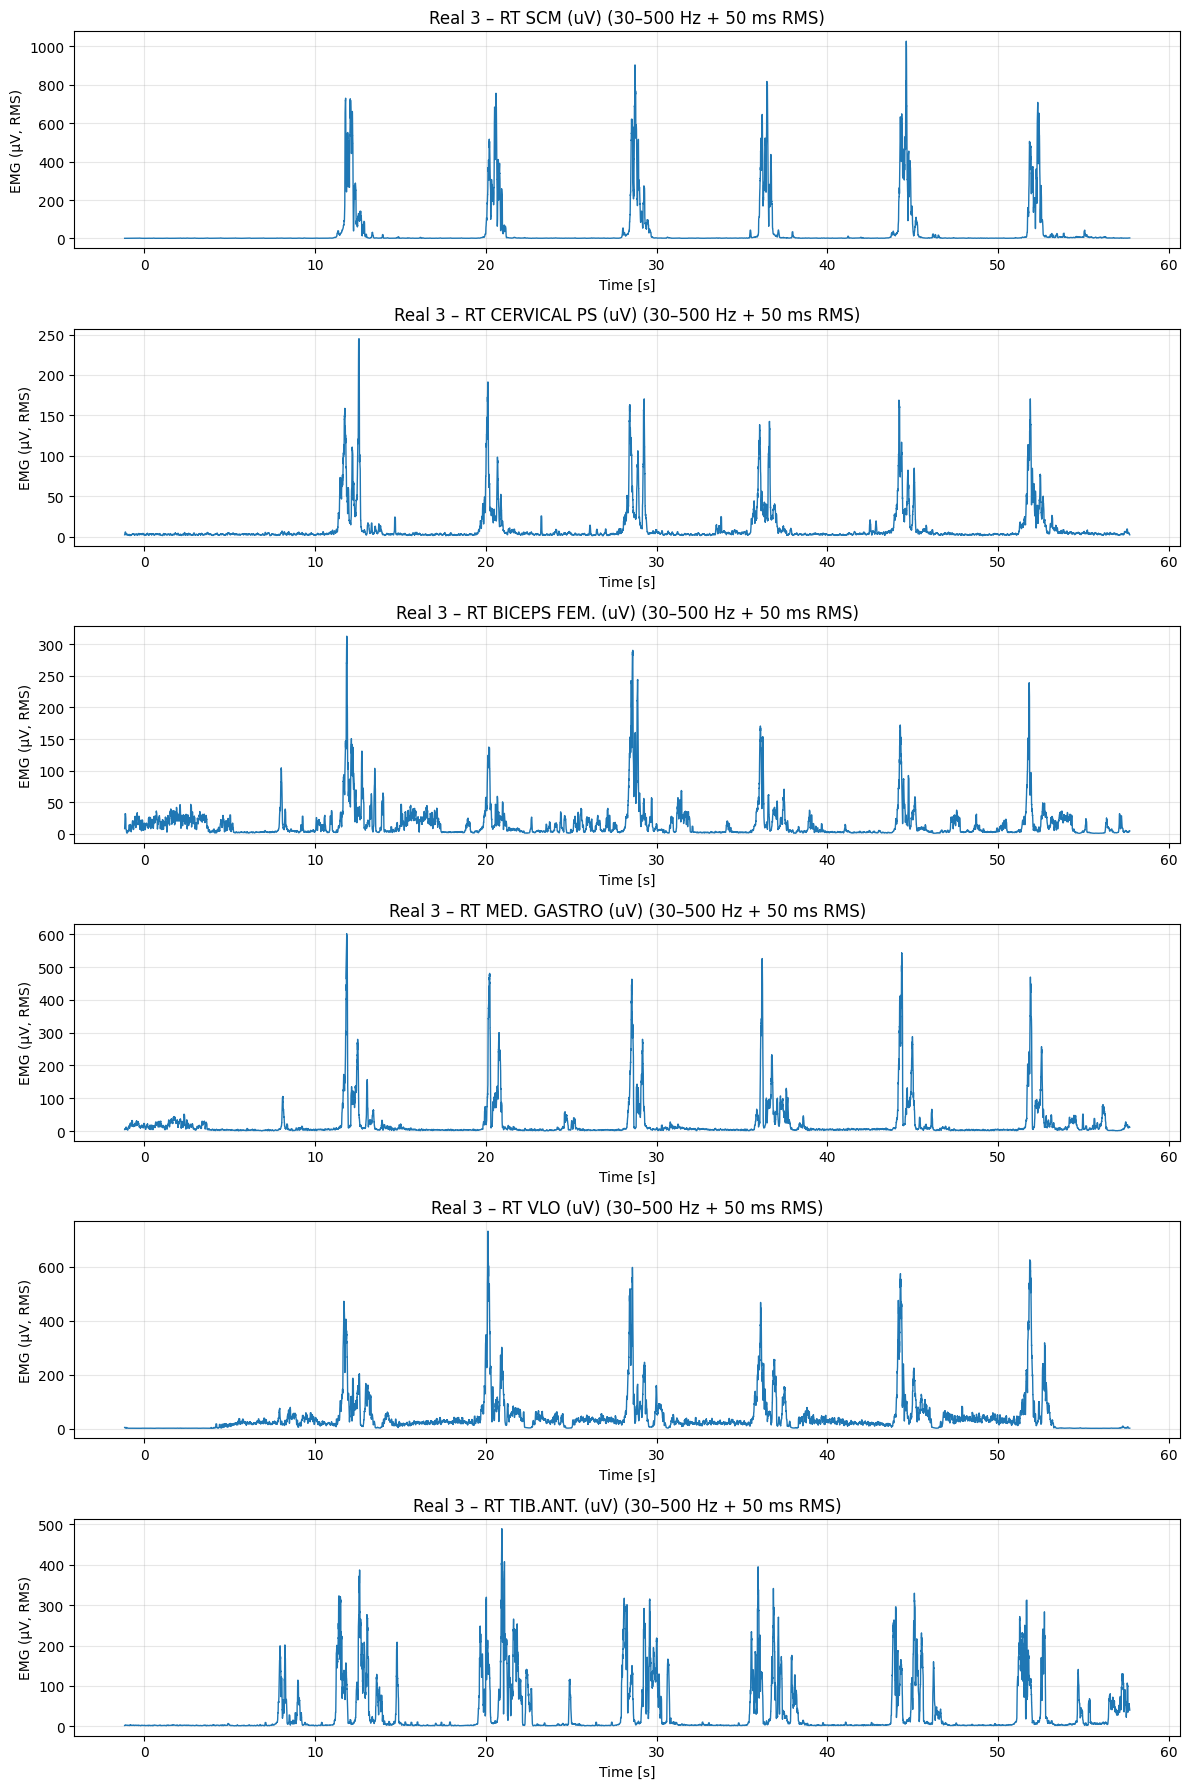

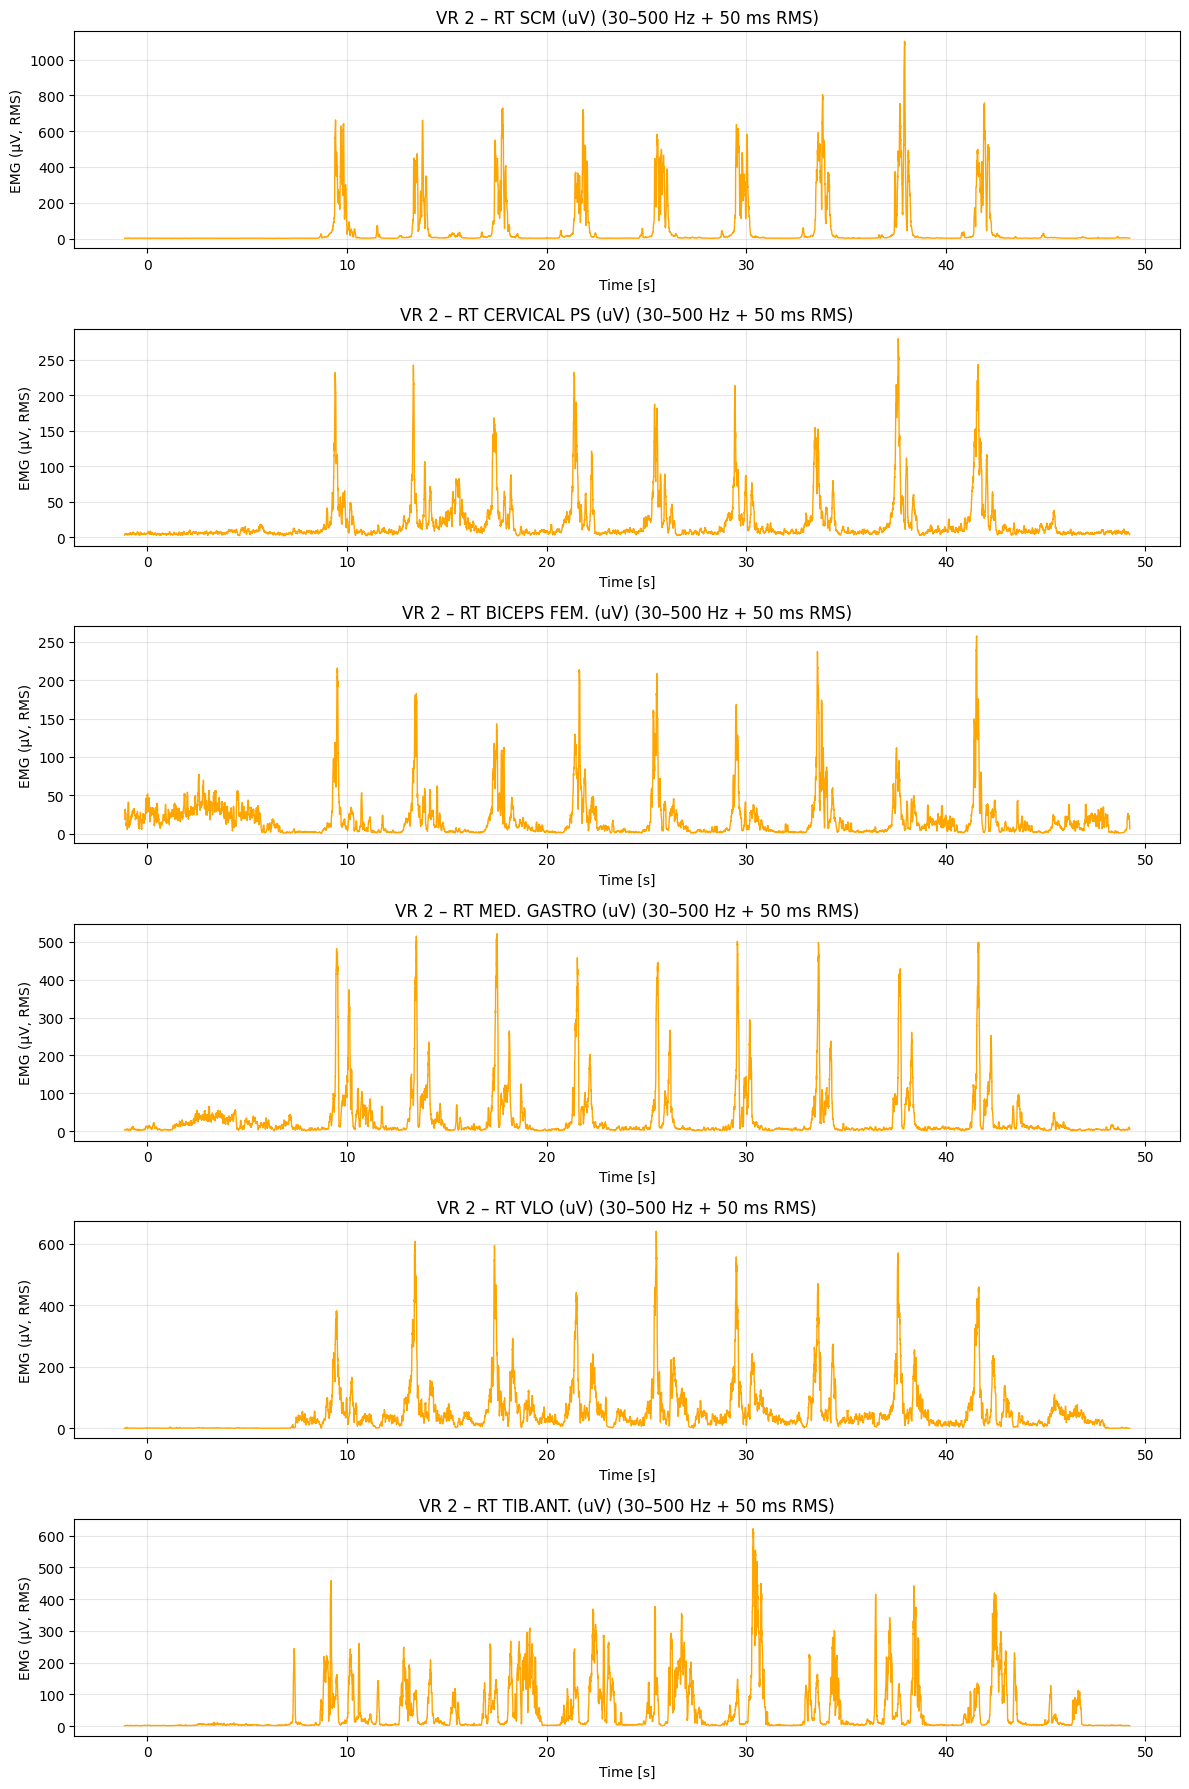

In [ ]:
## Filtern und plotten der EMG Daten von Real 3 und VR 2

# ---- Filter-Funktionen ----

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return b, a

def apply_notch(x, fs, f0=50, Q=30):
    b, a = iirnotch(f0, Q, fs)
    return filtfilt(b, a, x)

def rms_smoothing(x, fs, window_ms=50):
    """
    RMS-Glättung über ein Fenster in Millisekunden.
    """
    window_samples = int(round(fs * window_ms / 1000.0))
    if window_samples < 1:
        window_samples = 1
    # RMS: sqrt( gleitender Mittelwert von x^2 )
    x_sq = x ** 2
    kernel = np.ones(window_samples) / window_samples
    mean_sq = np.convolve(x_sq, kernel, mode='same')
    return np.sqrt(mean_sq)

def preprocess_emg(df, emg_cols, fs):
    """
    Filtert EMG: Bandpass 30–500 Hz, 50 Hz Notch, RMS 50 ms.
    """
    out = df.copy()
    b_bp, a_bp = butter_bandpass(30, 500, fs)

    for muscle in emg_cols:
        raw = df[muscle].astype(float).values

        # 1) Bandpass 30–500 Hz
        bp = filtfilt(b_bp, a_bp, raw)

        # 2) 50 Hz Notch
        notch = apply_notch(bp, fs, f0=50)

        # 3) RMS 50 ms (inkl. Rektifikation)
        rms = rms_smoothing(notch, fs, window_ms=50)

        out[muscle + '_filtered'] = rms

    return out


# ---- Filtern ----

fs = 2000  # falls deine Samplingrate anders ist: hier ändern!

emg_cols = [
    'RT SCM (uV)',
    'RT CERVICAL PS (uV)',
    'RT BICEPS FEM. (uV)',
    'RT MED. GASTRO (uV)',
    'RT VLO (uV)',
    'RT TIB.ANT. (uV)'
]

real3_filtered = preprocess_emg(data_real3, emg_cols, fs)
vr2_filtered   = preprocess_emg(data_vr2, emg_cols, fs)

print("Filtering (30–500 Hz + 50 ms RMS) abgeschlossen.")


# ---- Plot: Real3 gefiltert ----

plt.figure(figsize=(12, 18))
for i, muscle in enumerate(emg_cols, 1):
    plt.subplot(6, 1, i)
    plt.plot(real3_filtered['time'], real3_filtered[muscle + '_filtered'], linewidth=1)
    plt.title(f"Real 3 – {muscle} (30–500 Hz + 50 ms RMS)")
    plt.xlabel("Time [s]")
    plt.ylabel("EMG (µV, RMS)")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# ---- Plot: VR2 gefiltert ----

plt.figure(figsize=(12, 18))
for i, muscle in enumerate(emg_cols, 1):
    plt.subplot(6, 1, i)
    plt.plot(vr2_filtered['time'], vr2_filtered[muscle + '_filtered'], linewidth=1, color="orange")
    plt.title(f"VR 2 – {muscle} (30–500 Hz + 50 ms RMS)")
    plt.xlabel("Time [s]")
    plt.ylabel("EMG (µV, RMS)")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

MVC-Filtering (30–500 Hz + 50 ms RMS) abgeschlossen.


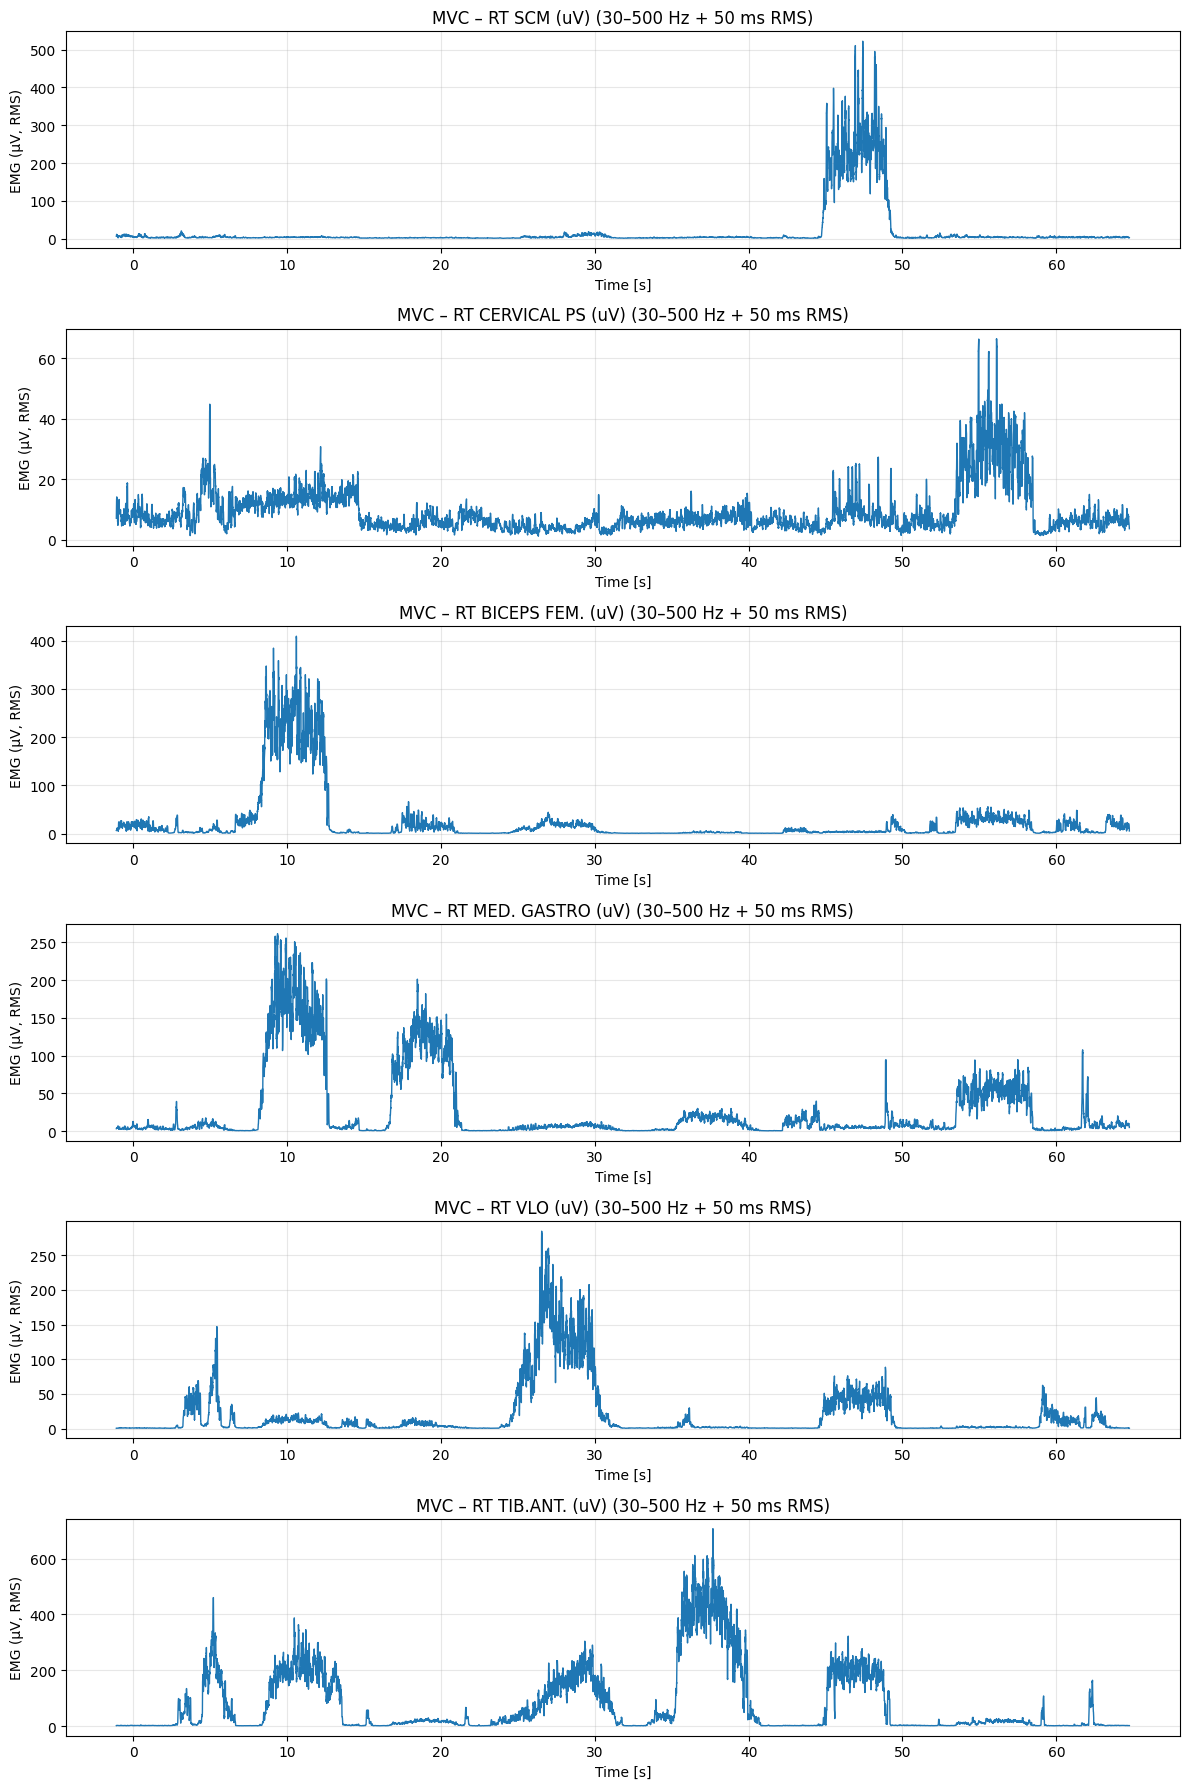

In [10]:
# MVC mit derselben Pipeline filtern: 30–500 Hz + 50 ms RMS

mvc_filtered = preprocess_emg(data_mvc, emg_cols, fs)

print("MVC-Filtering (30–500 Hz + 50 ms RMS) abgeschlossen.")


# ---- Plot: MVC gefiltert ----

plt.figure(figsize=(12, 18))
for i, muscle in enumerate(emg_cols, 1):
    plt.subplot(6, 1, i)
    plt.plot(mvc_filtered['time'], mvc_filtered[muscle + '_filtered'], linewidth=1)
    plt.title(f"MVC – {muscle} (30–500 Hz + 50 ms RMS)")
    plt.xlabel("Time [s]")
    plt.ylabel("EMG (µV, RMS)")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
## MVC Peaks berechnen und Normierung auf %MVC

# --- MVC-Peaks berechnen (aus gefiltertem MVC: 30–500 Hz + 50 ms RMS) ---

mvc_peaks = {}

for muscle in emg_cols:
    col_filt = muscle + '_filtered'
    if col_filt not in mvc_filtered.columns:
        print(f"Warnung: {col_filt} nicht in mvc_filtered gefunden – überspringe.")
        continue
    
    peak_val = mvc_filtered[col_filt].max(skipna=True)
    
    if np.isnan(peak_val) or peak_val <= 0:
        print(f"Warnung: Kein sinnvoller Peak für {muscle} gefunden – setze 1.0.")
        peak_val = 1.0
    
    mvc_peaks[muscle] = peak_val

print("MVC-Peaks (µV, RMS) pro Muskel:")
for m, v in mvc_peaks.items():
    print(f"{m}: {v:.2f} µV")


# --- Real3 & VR2 auf %MVC normieren ---

real3_norm = real3_filtered.copy()
vr2_norm   = vr2_filtered.copy()

for muscle in emg_cols:
    col_filt = muscle + '_filtered'
    if muscle not in mvc_peaks:
        continue
    
    mvc_val = mvc_peaks[muscle]
    
    if col_filt in real3_filtered.columns:
        real3_norm[muscle + '_%MVC'] = real3_filtered[col_filt] / mvc_val * 100.0
    if col_filt in vr2_filtered.columns:
        vr2_norm[muscle + '_%MVC']   = vr2_filtered[col_filt] / mvc_val * 100.0

print("\nNormierung abgeschlossen.")
print("Beispielspalten Real3:", [c for c in real3_norm.columns if '%MVC' in c])
print("Beispielspalten VR2:  ", [c for c in vr2_norm.columns if '%MVC' in c])

MVC-Peaks (µV, RMS) pro Muskel:
RT SCM (uV): 522.12 µV
RT CERVICAL PS (uV): 66.39 µV
RT BICEPS FEM. (uV): 409.04 µV
RT MED. GASTRO (uV): 261.39 µV
RT VLO (uV): 284.64 µV
RT TIB.ANT. (uV): 707.02 µV

Normierung abgeschlossen.
Beispielspalten Real3: ['RT SCM (uV)_%MVC', 'RT CERVICAL PS (uV)_%MVC', 'RT BICEPS FEM. (uV)_%MVC', 'RT MED. GASTRO (uV)_%MVC', 'RT VLO (uV)_%MVC', 'RT TIB.ANT. (uV)_%MVC']
Beispielspalten VR2:   ['RT SCM (uV)_%MVC', 'RT CERVICAL PS (uV)_%MVC', 'RT BICEPS FEM. (uV)_%MVC', 'RT MED. GASTRO (uV)_%MVC', 'RT VLO (uV)_%MVC', 'RT TIB.ANT. (uV)_%MVC']


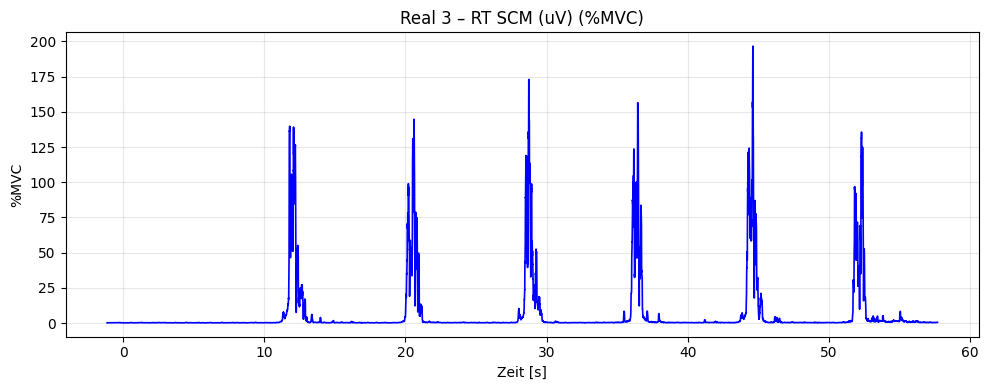

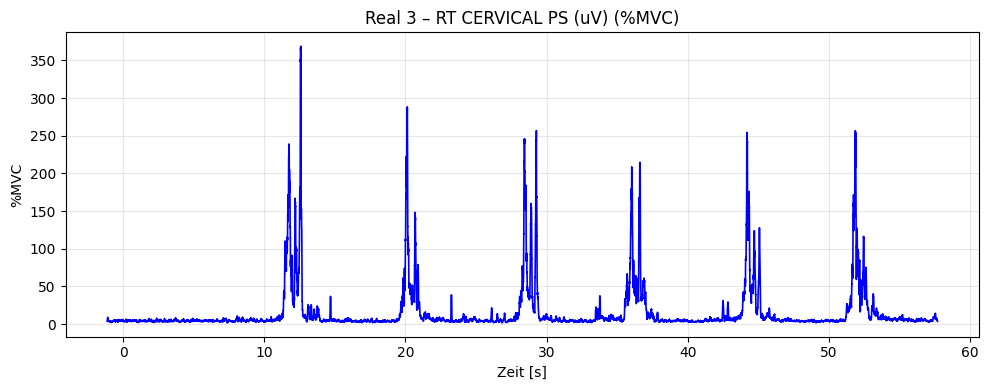

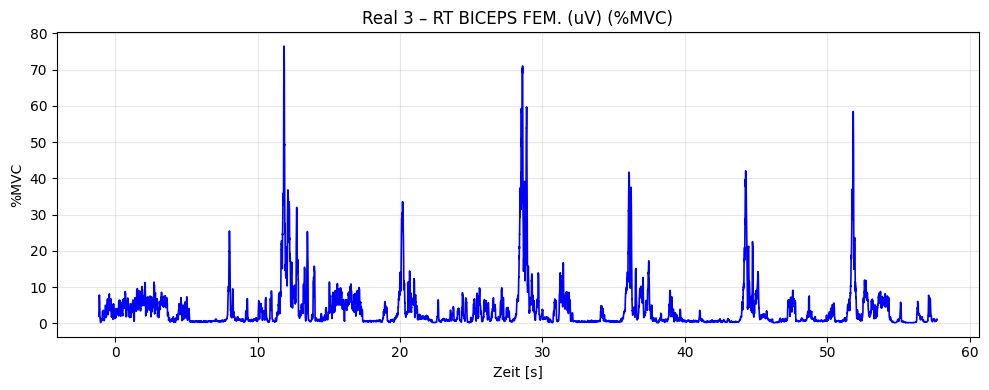

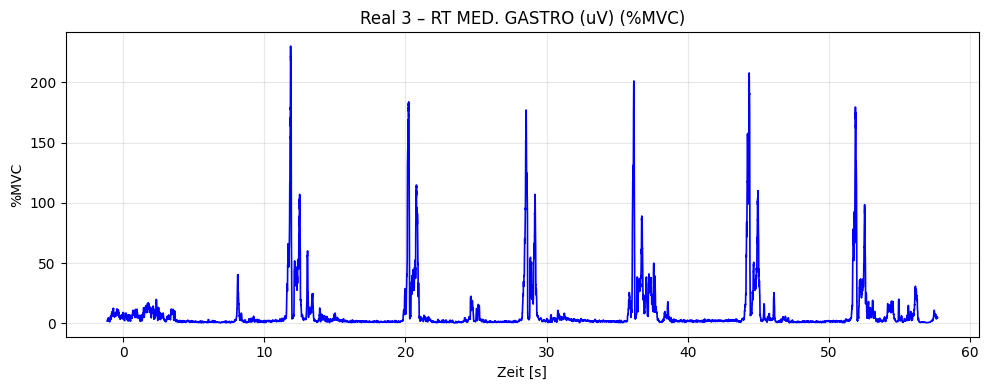

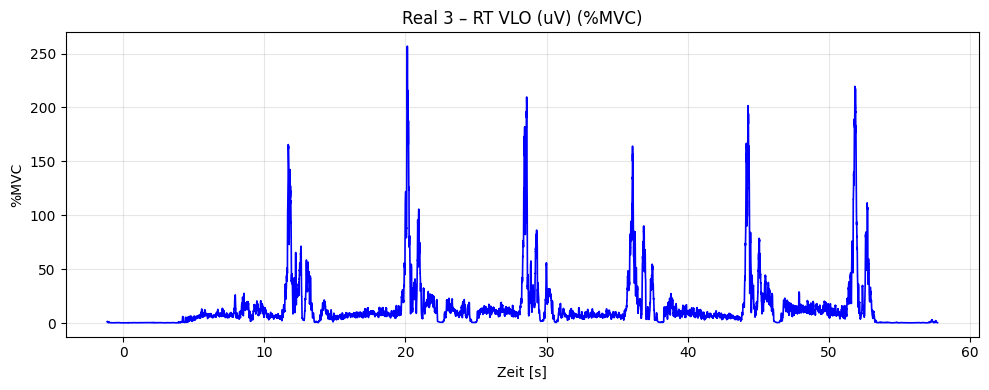

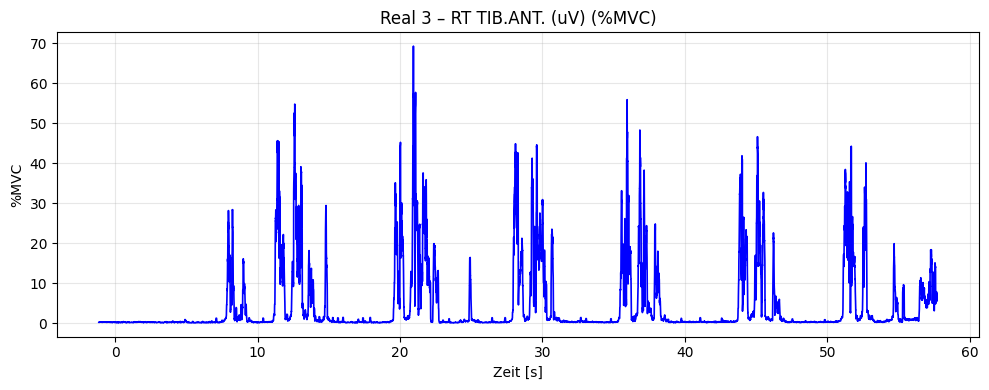

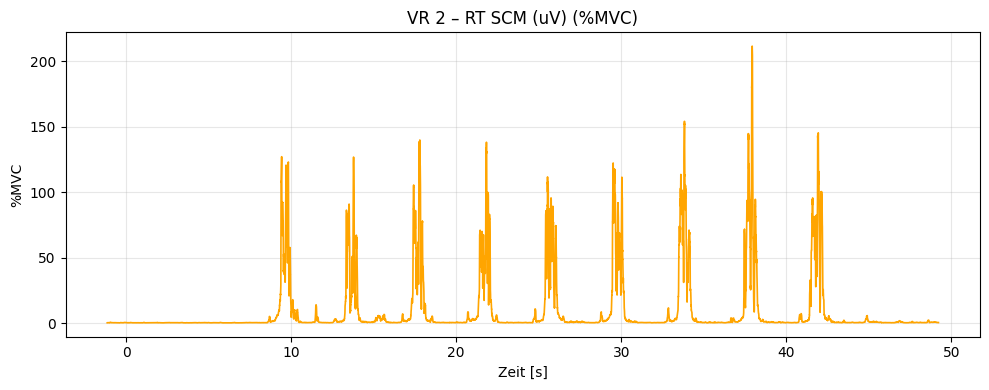

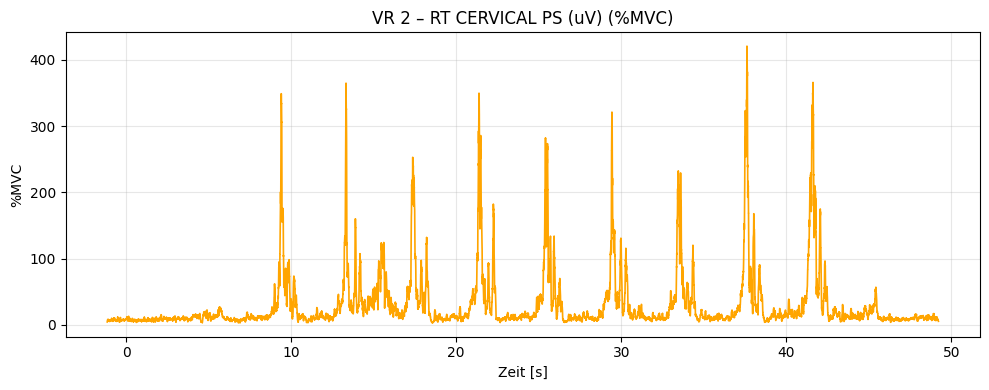

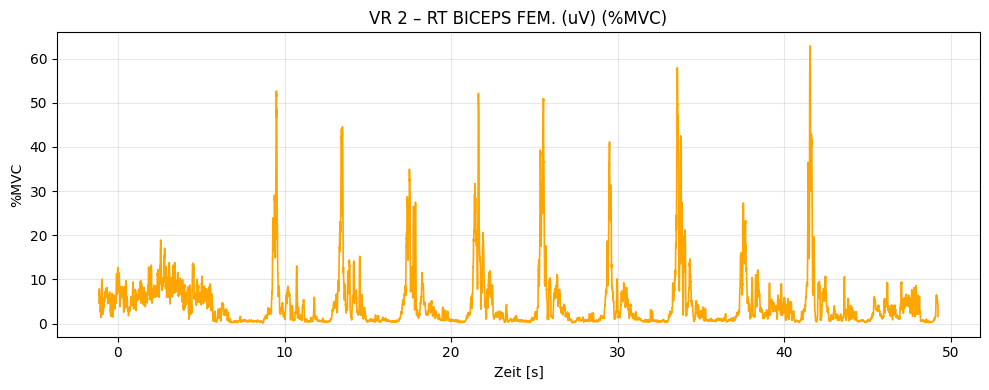

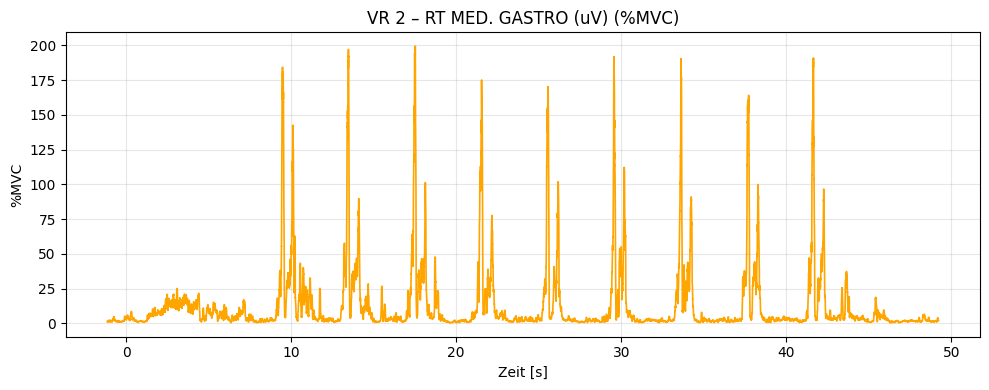

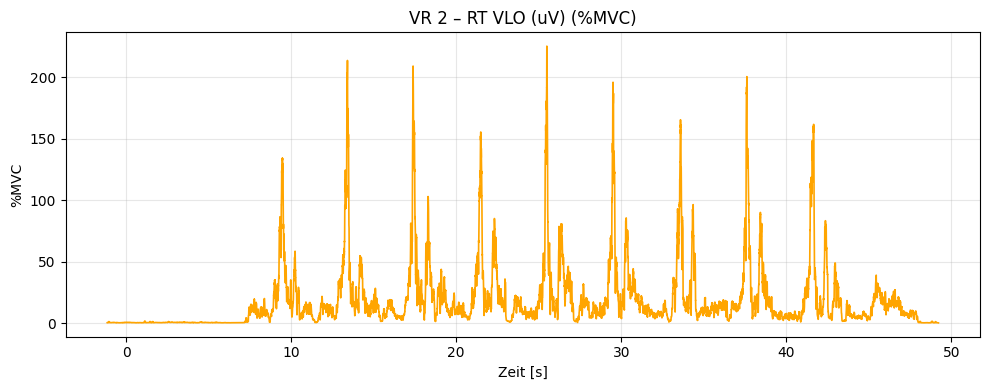

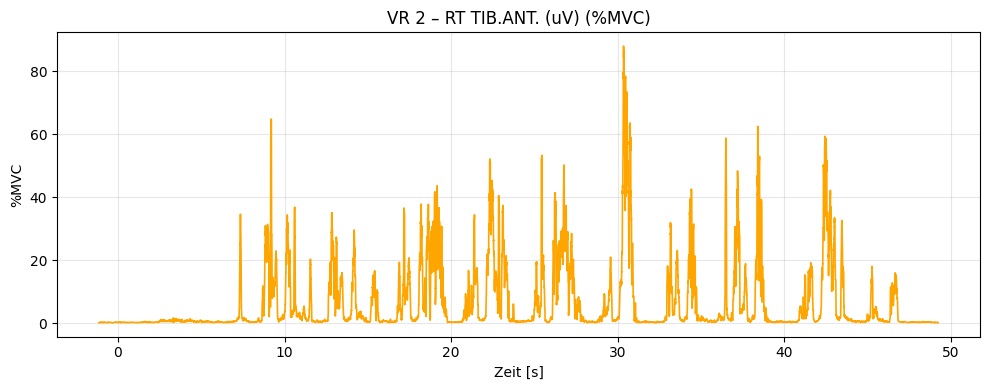

In [13]:
# Plots der normierten Daten (Real3)

for muscle in emg_cols:
    col_pct = muscle + "_%MVC"

    if col_pct not in real3_norm.columns:
        print(f"Spalte fehlt: {col_pct} – übersprungen.")
        continue

    plt.figure(figsize=(10, 4))
    plt.plot(real3_norm["time"], real3_norm[col_pct], linewidth=1.2, color="blue")

    plt.title(f"Real 3 – {muscle} (%MVC)")
    plt.xlabel("Zeit [s]")
    plt.ylabel("%MVC")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Plots der normierten Daten (VR2)

for muscle in emg_cols:
    col_pct = muscle + "_%MVC"

    if col_pct not in vr2_norm.columns:
        print(f"Spalte fehlt: {col_pct} – übersprungen.")
        continue

    plt.figure(figsize=(10, 4))
    plt.plot(vr2_norm["time"], vr2_norm[col_pct], linewidth=1.2, color="orange")

    plt.title(f"VR 2 – {muscle} (%MVC)")
    plt.xlabel("Zeit [s]")
    plt.ylabel("%MVC")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Starkes Filtering (30–500 Hz + 50 Hz Notch + RMS 100 ms) abgeschlossen.

MVC-Peaks (stark gefiltert, µV RMS):
RT SCM (uV): 444.84 µV
RT CERVICAL PS (uV): 56.06 µV
RT BICEPS FEM. (uV): 359.89 µV
RT MED. GASTRO (uV): 236.99 µV
RT VLO (uV): 234.84 µV
RT TIB.ANT. (uV): 599.42 µV

Normierung (stark gefiltert) abgeschlossen.
Beispielspalten Real3 (strong): ['RT SCM (uV)_%MVC_strong', 'RT CERVICAL PS (uV)_%MVC_strong', 'RT BICEPS FEM. (uV)_%MVC_strong', 'RT MED. GASTRO (uV)_%MVC_strong', 'RT VLO (uV)_%MVC_strong', 'RT TIB.ANT. (uV)_%MVC_strong']
Beispielspalten VR2  (strong): ['RT SCM (uV)_%MVC_strong', 'RT CERVICAL PS (uV)_%MVC_strong', 'RT BICEPS FEM. (uV)_%MVC_strong', 'RT MED. GASTRO (uV)_%MVC_strong', 'RT VLO (uV)_%MVC_strong', 'RT TIB.ANT. (uV)_%MVC_strong']


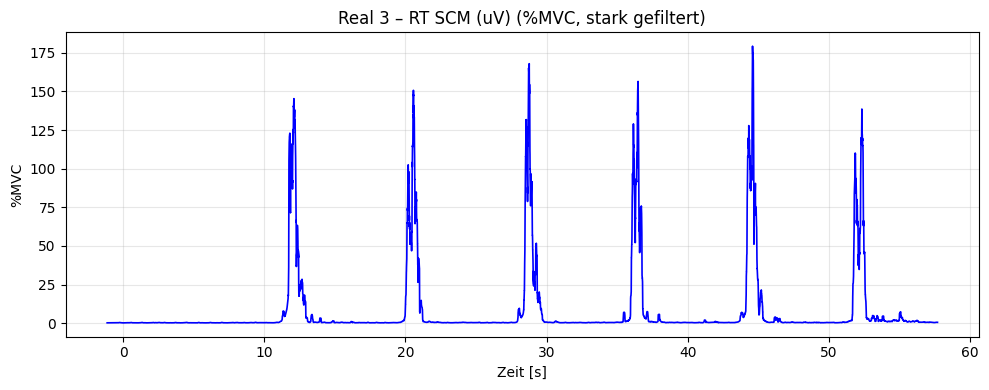

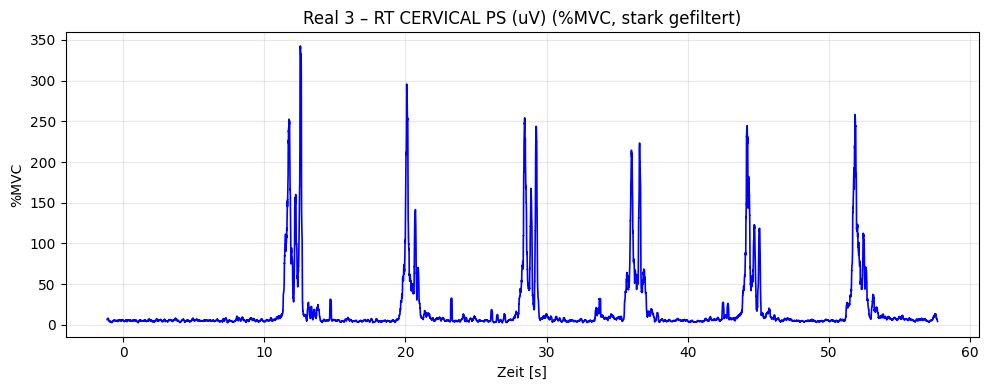

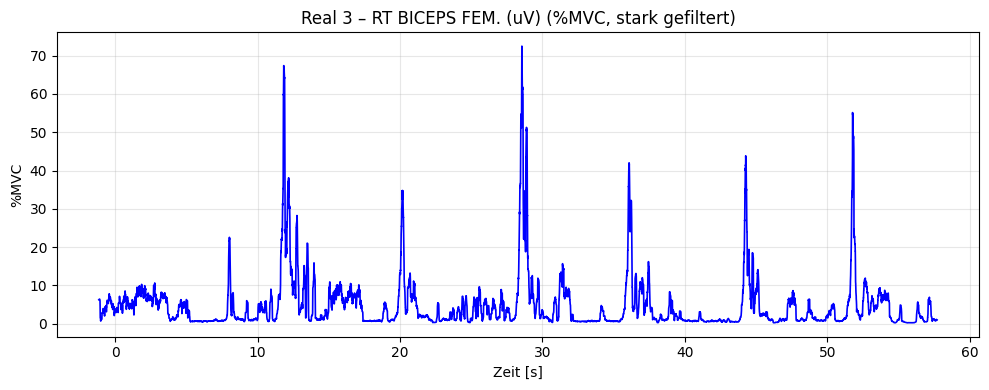

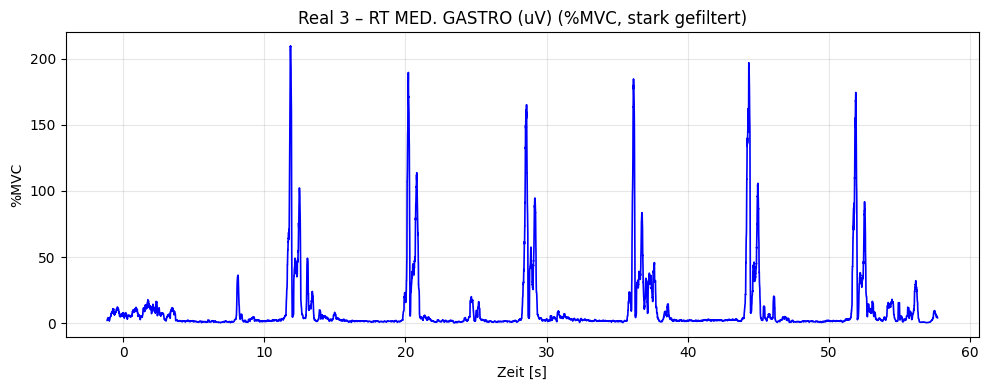

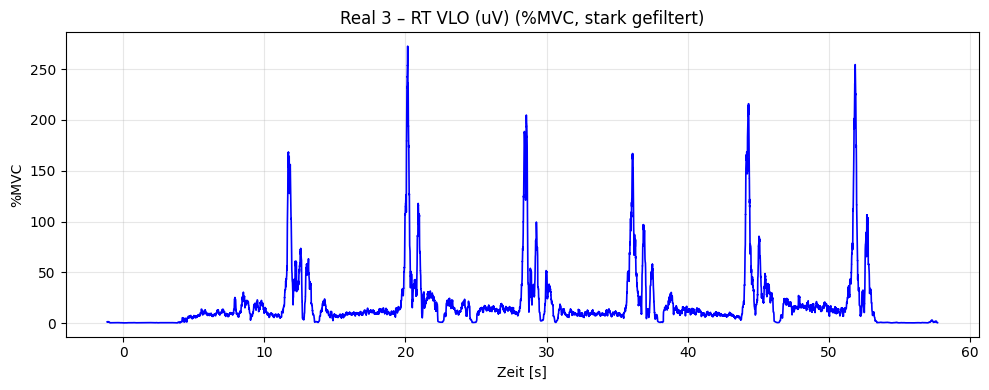

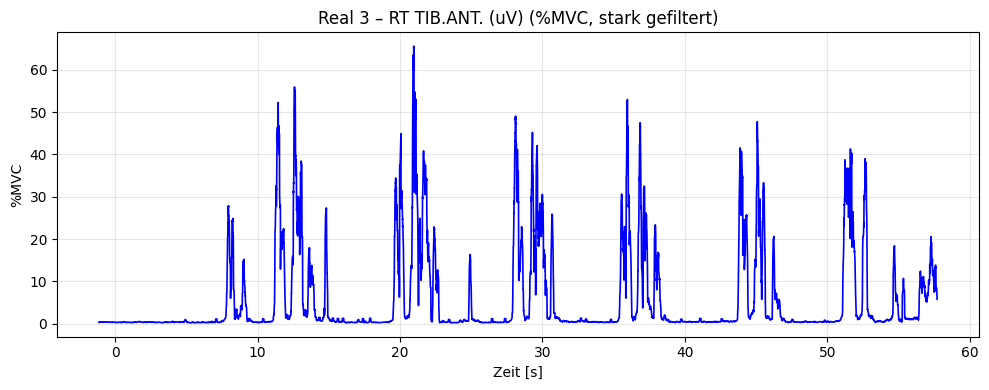

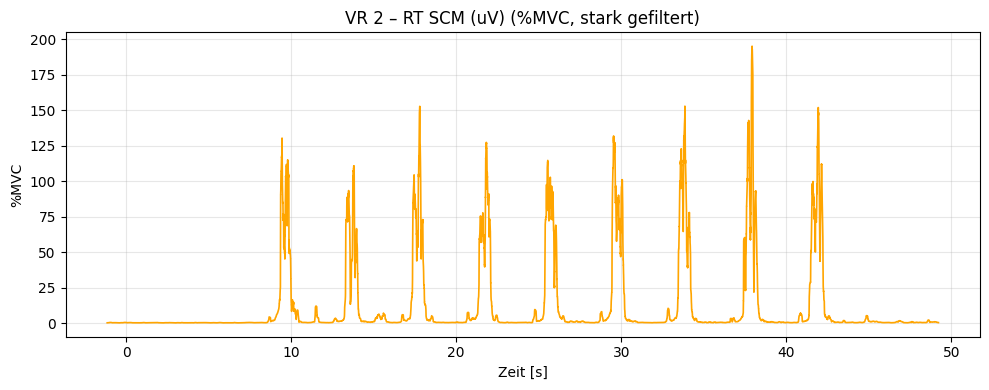

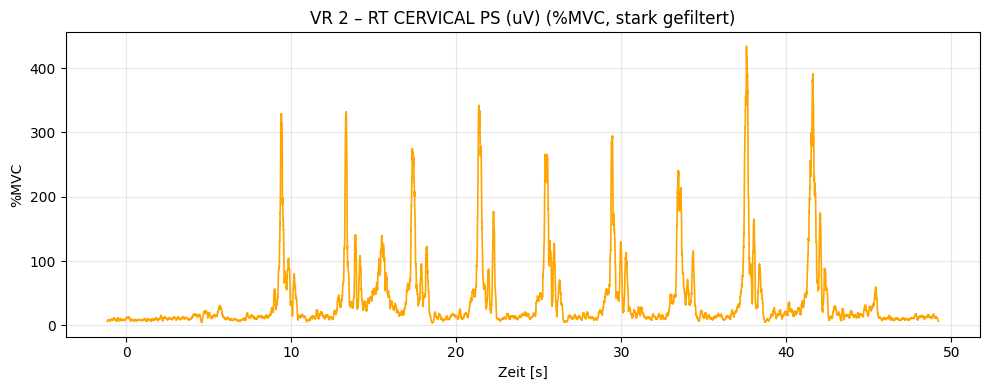

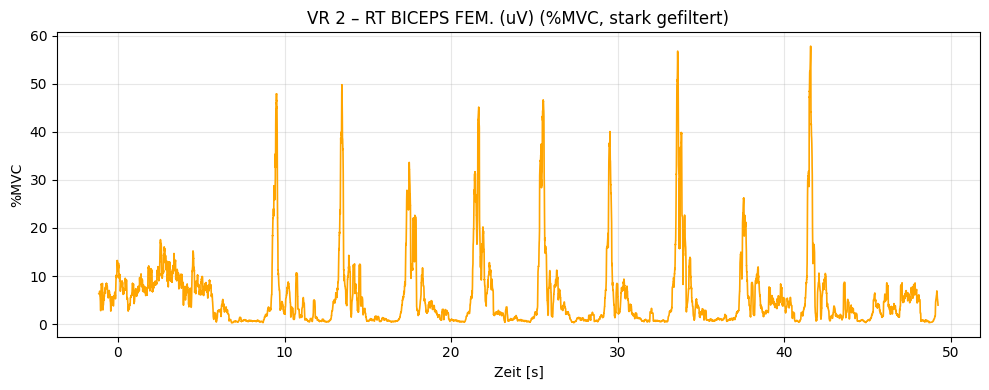

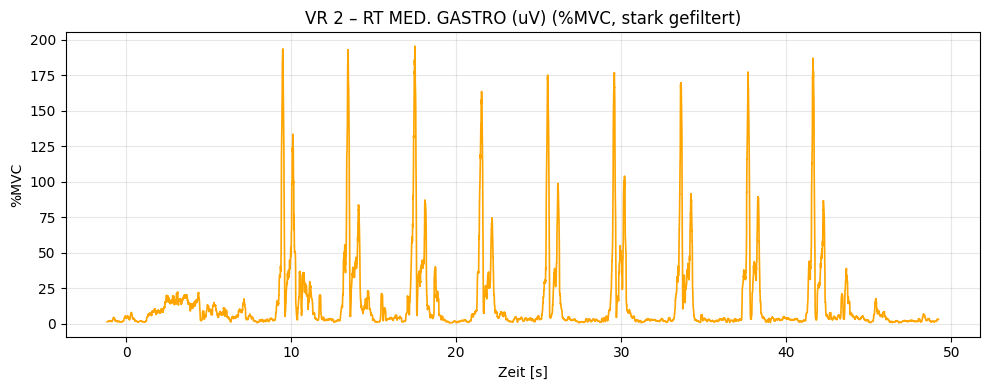

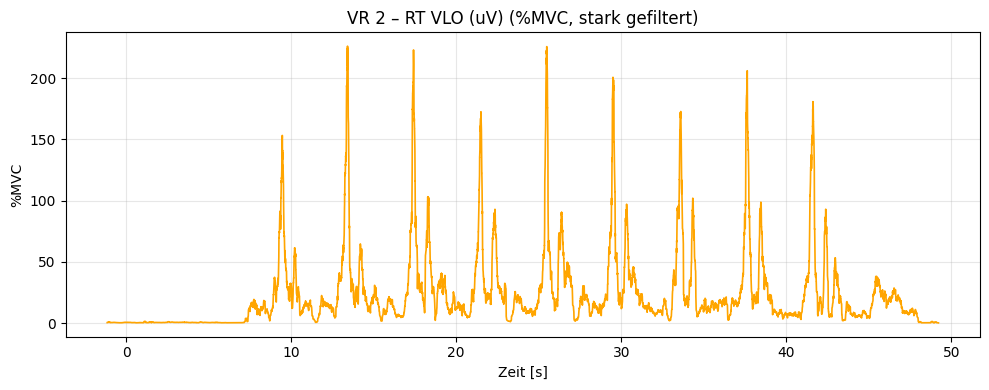

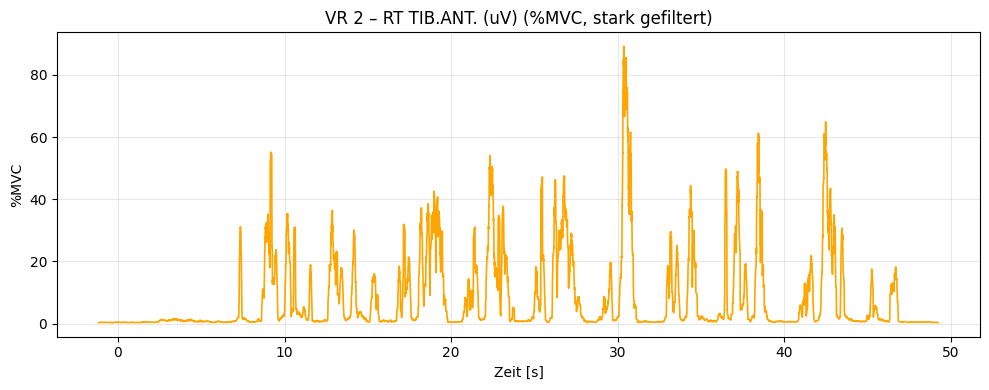

In [14]:
# ---------- Stärkeres Filtering: 30–500 Hz + 50 Hz Notch + RMS 100 ms ----------

def butter_bandpass_strong(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return b, a

def apply_notch(x, fs, f0=50, Q=30):
    b, a = iirnotch(f0, Q, fs)
    return filtfilt(b, a, x)

def rms_smoothing(x, fs, window_ms=100):
    """
    RMS-Glättung mit größerem Fenster (100 ms) -> deutlich glattere Kurven.
    """
    window_samples = int(round(fs * window_ms / 1000.0))
    if window_samples < 1:
        window_samples = 1
    x_sq = x ** 2
    kernel = np.ones(window_samples) / window_samples
    mean_sq = np.convolve(x_sq, kernel, mode='same')
    return np.sqrt(mean_sq)

def preprocess_emg_strong(df, emg_cols, fs):
    """
    Stärkere EMG-Filterung:
    - Bandpass 30–500 Hz
    - 50 Hz Notch
    - RMS 100 ms
    """
    out = df.copy()
    b_bp, a_bp = butter_bandpass_strong(30, 500, fs)

    for muscle in emg_cols:
        raw = df[muscle].astype(float).values

        # 1) Bandpass
        bp = filtfilt(b_bp, a_bp, raw)

        # 2) 50 Hz Notch
        notch = apply_notch(bp, fs, f0=50)

        # 3) RMS 100 ms
        rms = rms_smoothing(notch, fs, window_ms=100)

        out[muscle + '_filtered_strong'] = rms

    return out


# ---------- 1. Stärker filtern: Real3, VR2, MVC ----------

real3_filtered_strong = preprocess_emg_strong(data_real3, emg_cols, fs)
vr2_filtered_strong   = preprocess_emg_strong(data_vr2,   emg_cols, fs)
mvc_filtered_strong   = preprocess_emg_strong(data_mvc,   emg_cols, fs)

print("Starkes Filtering (30–500 Hz + 50 Hz Notch + RMS 100 ms) abgeschlossen.")


# ---------- 2. MVC-Peaks aus der stärker gefilterten MVC bestimmen ----------

mvc_peaks_strong = {}

for muscle in emg_cols:
    col_filt = muscle + "_filtered_strong"
    if col_filt not in mvc_filtered_strong.columns:
        print(f"Warnung: {col_filt} nicht in mvc_filtered_strong – überspringe.")
        continue

    peak_val = mvc_filtered_strong[col_filt].max(skipna=True)
    if np.isnan(peak_val) or peak_val <= 0:
        print(f"Warnung: Kein sinnvoller Peak für {muscle} (stark gefiltert) – setze 1.0.")
        peak_val = 1.0

    mvc_peaks_strong[muscle] = peak_val

print("\nMVC-Peaks (stark gefiltert, µV RMS):")
for m, v in mvc_peaks_strong.items():
    print(f"{m}: {v:.2f} µV")


# ---------- 3. Real3 & VR2 auf %MVC (stark gefiltert) normieren ----------

real3_norm_strong = real3_filtered_strong.copy()
vr2_norm_strong   = vr2_filtered_strong.copy()

for muscle in emg_cols:
    col_filt = muscle + "_filtered_strong"
    if muscle not in mvc_peaks_strong:
        continue

    mvc_val = mvc_peaks_strong[muscle]

    if col_filt in real3_filtered_strong.columns:
        real3_norm_strong[muscle + "_%MVC_strong"] = real3_filtered_strong[col_filt] / mvc_val * 100.0
    if col_filt in vr2_filtered_strong.columns:
        vr2_norm_strong[muscle + "_%MVC_strong"]   = vr2_filtered_strong[col_filt] / mvc_val * 100.0

print("\nNormierung (stark gefiltert) abgeschlossen.")
print("Beispielspalten Real3 (strong):", [c for c in real3_norm_strong.columns if '%MVC_strong' in c])
print("Beispielspalten VR2  (strong):", [c for c in vr2_norm_strong.columns if '%MVC_strong' in c])


# ---------- 4. Plots: jeder Muskel einzeln, stark gefilterte %MVC ----------

# Real3 – stark gefiltert, %MVC
for muscle in emg_cols:
    col_pct = muscle + "_%MVC_strong"
    if col_pct not in real3_norm_strong.columns:
        print(f"Spalte fehlt (Real3 strong): {col_pct} – übersprungen.")
        continue

    plt.figure(figsize=(10, 4))
    plt.plot(real3_norm_strong["time"], real3_norm_strong[col_pct], linewidth=1.2, color="blue")
    plt.title(f"Real 3 – {muscle} (%MVC, stark gefiltert)")
    plt.xlabel("Zeit [s]")
    plt.ylabel("%MVC")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# VR2 – stark gefiltert, %MVC
for muscle in emg_cols:
    col_pct = muscle + "_%MVC_strong"
    if col_pct not in vr2_norm_strong.columns:
        print(f"Spalte fehlt (VR2 strong): {col_pct} – übersprungen.")
        continue

    plt.figure(figsize=(10, 4))
    plt.plot(vr2_norm_strong["time"], vr2_norm_strong[col_pct], linewidth=1.2, color="orange")
    plt.title(f"VR 2 – {muscle} (%MVC, stark gefiltert)")
    plt.xlabel("Zeit [s]")
    plt.ylabel("%MVC")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()